# Проект "Маркетинг"    
Интернет-магазин собирает историю покупателей, проводит рассылки предложений и
планирует будущие продажи. Для оптимизации процессов надо выделить пользователей,
которые готовы совершить покупку в ближайшее время.     

### Цель исследования:     
Построить модель машинного обучения, которая для каждого клиента сможет предсказать вероятность покупки в интернет-магазине в течение 90 дней, проверить качество модели метрикой ROC-AUC.     

### План проекта:    
Шаг 1. Подготовка данных          
Загрузка и предобработка данных: обработка пропусков, дубликатов, аномалий, проверка типов данных;   
Объединение таблиц, разработка новых признаков;     
Исследовательский анализ данных: исследование и корреляционный анализ признаков;    
Подготовка выборок для обучения моделей;        
Вывод по разделу     

Шаг 2. Обучение моделей    
Создание пайплайна, обучение и получение предсказаний следующих моделей: LogisticRegression, KNeighborsClassifier и CatBoostRegressor;     
Выбор лучшей модели;      
Вывод по разделу         

Шаг 3. Анализ моделей  
Получение предсказания, определение качества лучшей модели (метрикой ROC-AUC), анализ признаков и ошибок;    
Вывод по разделу     

Шаг 4. Общий вывод и рекомендации       

### Описание изначальных данных:       
1. apparel-purchases (история покупок):       
● client_id - идентификатор пользователя;    
● quantity - количество товаров в заказе;    
● price - цена товара;    
● category_ids - вложенные категории, к которым относится товар;    
● date - дата покупки;    
● message_id - идентификатор сообщения из рассылки;    

2. apparel-messages (история рекламных рассылок):      
● bulk_campaign_id - идентификатор рекламной кампании;    
● client_id - идентификатор пользователя;   
● message_id - идентификатор сообщений;   
● event - тип действия;   
● channel - канал рассылки;    
● date - дата рассылки;    
● created_at - точное время создания сообщения;    

3. apparel-target_binary (совершит ли клиент покупку в течение следующих 90 дней):     
● client_id - идентификатор пользователя;     
● target - целевой признак.

### Шаг 1. Подготовка данных:

In [1]:
import pandas as pd
import numpy as np
import phik
import plotly.express as px
import matplotlib
import seaborn as sns
import shap

from datetime import date
from matplotlib import pyplot as plt
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder 
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (roc_auc_score, RocCurveDisplay, confusion_matrix)

pd.set_option('display.float_format', '{:,.2f}'.format)

In [2]:
def to_open(data):
    display(data.head())
    display(data.info())
    display(data.describe())

In [3]:
purchases = pd.read_csv("/kaggle/input/masterskayaproject2/apparel-purchases.csv")
to_open(purchases)

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,"1,999.00","['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,"2,499.00","['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,"6,499.00","['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,"4,999.00","['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,"4,999.00","['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB


None

,client_id,quantity,price
count,"202,208.00","202,208.00","202,208.00"
mean,"1,515,915,625,596,210,944.00",1.01,"1,193.30"
std,"145,951,436.37",0.18,"1,342.25"
min,"1,515,915,625,468,060,928.00",1.00,1.00
25%,"1,515,915,625,490,081,280.00",1.00,352.00
50%,"1,515,915,625,557,177,088.00",1.00,987.00
75%,"1,515,915,625,624,391,936.00",1.00,"1,699.00"
max,"1,515,915,626,010,443,520.00",30.00,"85,499.00"


In [4]:
# Столбец с датой покупки приведем в формат дата-время
purchases['date'] = pd.to_datetime(purchases['date'], format='%Y-%m-%d')
# Создадим новый столбец 'year' с годом покупки
purchases['year'] = purchases['date'].dt.year

In [5]:
def duplicates(data, name):
    print('Явные дубликаты в', name, ':', data.duplicated().sum())

In [6]:
duplicates(purchases, 'purchases')

Явные дубликаты в purchases : 73020


По общей выгрузке заметили, что в основном одна покупка - это одна единица какого-то конкретного товара, допускаем, что один клиент мог совершить несколько одинаковых покупок, поэтому в данном случае не будем считать явные дубликаты аномалиями - удалять их не будем.

In [7]:
def values(data):
    for index in data:
        print("Уникальные значения в столбце:", index)
        display(data[index].value_counts())

In [8]:
# Разобьем вложенные категории на составляющие элементы (на отдельные числа между запятыми), чтобы изучить категории товара - всего 5 элементов
purchases['category_ids'] = purchases['category_ids'].str.replace('[', '').str.replace(']', '').str.replace("'", '').str.replace("None", '0').str.strip()

purchases[['category_ids_1', 
           'category_ids_2',
           'category_ids_3', 
           'category_ids_4', 
           'category_ids_5']] = purchases['category_ids'].str.split(',', expand=True)

purchases[['category_ids_1', 
           'category_ids_2', 
           'category_ids_3', 
           'category_ids_4', 
           'category_ids_5']] = purchases[['category_ids_1', 
                                           'category_ids_2', 
                                           'category_ids_3', 
                                           'category_ids_4', 
                                           'category_ids_5']].fillna(0)

purchases.loc[purchases['category_ids_1'] == '', 'category_ids_1'] = '0'

purchases.head()

,client_id,quantity,price,category_ids,date,message_id,year,category_ids_1,category_ids_2,category_ids_3,category_ids_4,category_ids_5
0,1515915625468169594,1,"1,999.00","4, 28, 57, 431",2022-05-16,1515915625468169594-4301-627b661e9736d,2022,4,28,57,431,0
1,1515915625468169594,1,"2,499.00","4, 28, 57, 431",2022-05-16,1515915625468169594-4301-627b661e9736d,2022,4,28,57,431,0
2,1515915625471138230,1,"6,499.00","4, 28, 57, 431",2022-05-16,1515915625471138230-4437-6282242f27843,2022,4,28,57,431,0
3,1515915625471138230,1,"4,999.00","4, 28, 244, 432",2022-05-16,1515915625471138230-4437-6282242f27843,2022,4,28,244,432,0
4,1515915625471138230,1,"4,999.00","4, 28, 49, 413",2022-05-16,1515915625471138230-4437-6282242f27843,2022,4,28,49,413,0


In [9]:
values(purchases)

Уникальные значения в столбце: client_id


client_id
1515915625853312319    346
1515915625624308268    218
1515915625607113301    210
1515915625500232103    131
1515915625470860261    131
                      ... 
1515915625559962326      1
1515915625559941251      1
1515915625468133517      1
1515915625559866916      1
1515915626010443624      1
Name: count, Length: 49849, dtype: int64

Уникальные значения в столбце: quantity


quantity
1     201323
2        751
3         94
4         12
6          5
10         4
20         3
15         3
5          3
25         2
30         2
9          2
13         1
18         1
8          1
7          1
Name: count, dtype: int64

Уникальные значения в столбце: price


price
999.00      10233
1,499.00     7520
1,999.00     7150
699.00       6044
599.00       5612
            ...  
2,591.00        1
2,084.00        1
2,476.00        1
2,793.00        1
2,789.00        1
Name: count, Length: 3642, dtype: int64

Уникальные значения в столбце: category_ids


category_ids
4, 28, 57, 431            8626
4, 28, 260, 420           6989
4, 28, 244, 432           6821
                          5579
4, 28, 275, 421           4936
                          ... 
4, 5837, 5836, 839           1
5562, 5632, 5552, 1089       1
4, 27, 278, 471              1
5562, 5697, 5651, 1153       1
5562, 5597, 5696, 5529       1
Name: count, Length: 933, dtype: int64

Уникальные значения в столбце: date


date
2022-11-11    5270
2023-06-10    3836
2023-04-28    3473
2022-11-15    2937
2022-12-22    2631
              ... 
2023-08-06       4
2023-10-29       4
2023-01-09       3
2022-10-06       2
2023-01-29       2
Name: count, Length: 642, dtype: int64

Уникальные значения в столбце: message_id


message_id
1515915625489095763-6251-6311b13a4cf78     365
1515915625624308268-7803-636dfea7ca890     218
1515915625880116527-8725-639b2f0ad5e2e     160
1515915625607113301-13818-650a8af70fd67    148
1515915625558691508-14212-6567128370bdd    143
                                          ... 
1515915625487887289-5707-62e38257ccade       1
1515915625597731503-5707-62e38247a88c0       1
1515915625594604191-5707-62e382458eb5f       1
1515915625594340883-5739-62e3d2d9c35c2       1
1515915625495329923-5707-62e382401e741       1
Name: count, Length: 50204, dtype: int64

Уникальные значения в столбце: year


year
2023    109680
2022     81621
2024     10907
Name: count, dtype: int64

Уникальные значения в столбце: category_ids_1


category_ids_1
4       112578
5562     46511
2        27429
6060      7559
0         6843
5963      1272
3           11
1            3
5            2
Name: count, dtype: int64

Уникальные значения в столбце: category_ids_2


category_ids_2
 28      80143
 18      24314
 27      12216
 5630     9753
 31       8507
 5631     8323
0         6843
 5589     6206
 5633     5733
 6058     5543
 5536     5366
 29       5049
 5634     4928
 1822     4499
 17       3115
 5597     2356
 5632     1856
 44       1303
 5959     1272
 5683     1157
 6057     1078
 6059      938
 5837      763
 5558      430
 5599      306
 30         98
 5697       97
 12          7
 14          4
 22          2
 10          2
 8           1
Name: count, dtype: int64

Уникальные значения в столбце: category_ids_3


category_ids_3
260     8853
62      8675
57      8626
275     8433
258     7277
        ... 
50         2
5617       1
1600       1
5651       1
280        1
Name: count, Length: 292, dtype: int64

Уникальные значения в столбце: category_ids_4


category_ids_4
 431     8626
0        8199
 420     6989
 432     6821
 421     4936
         ... 
 751        1
 5529       1
 1775       1
 1102       1
 5950       1
Name: count, Length: 839, dtype: int64

Уникальные значения в столбце: category_ids_5


category_ids_5
0       201690
 467       518
Name: count, dtype: int64

Столбцы с категориями товара состоят максимум из 5ти числовых значений. Первые значения не повторяются в дальнейших 4х числовых группах, могу предположить, что интернет-магазин имеет карточки товара, разбитые на группы, например: основная категория верхняя одежда может быть далее разложена на зимняя, весеняя и осенняя верхняя одежда, далее, например, шубы/дубленки, куртки/плащи, пальто и так далее. Для дальнейшей работы поэтому попробуем взять только первое числовое значение из 5ти. 

In [10]:
def not_filled(data):
    for index in data:
        if pd.isnull(data[index]).any == True:
            print("Пропуски в столбце:", index)
            display(data[pd.isnull(data[index])].head())
    display(data.isnull().sum())

In [11]:
not_filled(purchases)

client_id         0
quantity          0
price             0
category_ids      0
date              0
message_id        0
year              0
category_ids_1    0
category_ids_2    0
category_ids_3    0
category_ids_4    0
category_ids_5    0
dtype: int64

Пропуски в данных отсутствуют.

In [12]:
fig = px.histogram(
    purchases,
    x = 'price',
    marginal = 'box',
    opacity = 0.5,
    barmode = 'group',
    title = 'Распределение значений столбца price (цена товара)'
)
fig.update_layout(yaxis_title = 'Количество записей')
fig.show()

Магазин имеет широкий диапазон цен, нулевых значений цен в данных нет. Самый дешевый товар стоит 1 руб, самый дорогой товар - более 85 тыс руб., а медианная стоимость товара - около 900-1000 руб.

In [13]:
# Созданы столбцы 'quantity' с суммарным значением товаров и 'price' с суммарным значением стоимостей всех товаров для каждого отдельного клиента
purchases_group = purchases.groupby('client_id')[['quantity', 'price']].sum()

# Создан столбец 'total_sum' с итоговой стоимостью всех покупок для каждого отдельного клиента
purchases_group['total_sum'] = purchases_group['quantity'] * purchases_group['price']

# Создан столбец 'mean_price' со средней арифметической стоимостью всех товаров для каждого отдельного клиента
purchases_group['mean_price'] = purchases.groupby('client_id')['price'].mean()

# Создан столбец с количеством записей о покупках для каждого отдельного клиента
purchases_group['purchase_count'] = purchases.groupby('client_id')['date'].count()

# Созданы столбцы с последней и первой датой покупок для каждого отдельного клиента, далее был создан столбец 'purchase_last_first_date', который 
# отражает количество дней между последней и первой покупкой для каждого отдельного клиента, столбец приведен к целочисленному типу
purchases_group['purchase_last_date'] = purchases.groupby('client_id')['date'].max()
purchases_group['purchase_first_date'] = purchases.groupby('client_id')['date'].min()
purchases_group['purchase_last_first_date'] = purchases_group['purchase_last_date'] - purchases_group['purchase_first_date']
purchases_group['purchase_last_first_date'] = purchases_group['purchase_last_first_date'].dt.days.astype('int64')

# Создан столбец с основным годом покупки (год, в который каждый отдельный клиент чаще совершал покупки), столбец приведен к целочисленному типу
purchases_group['purchase_year'] = pd.pivot_table(purchases, values='year', index=['client_id'], aggfunc='max')['year']
purchases_group['purchase_year'] = purchases_group['purchase_year'].astype('int64') 

# Создан столбец с основной (первым значением вложенной категории, которое чаще всего встречалось среди всех покупок каждого клиента) 
# каатегорией товара
purchases_group['main_category'] = pd.pivot_table(purchases, values='category_ids_1', index=['client_id'], aggfunc='max')['category_ids_1']

# Удалены вспомогательные столбцы с датами
purchases_group = purchases_group.drop(columns=['purchase_last_date', 'purchase_first_date'])

purchases_group.head()

,quantity,price,total_sum,mean_price,purchase_count,purchase_last_first_date,purchase_year,main_category
client_id,,,,,,,,
1515915625468060902,7,"6,993.00","48,951.00",999.00,7,0,2022,4
1515915625468061003,7,"16,235.00","113,645.00","2,319.29",7,0,2023,4
1515915625468061099,1,299.00,299.00,299.00,1,0,2022,4
1515915625468061100,2,"2,098.00","4,196.00","1,049.00",2,0,2024,4
1515915625468061170,19,"33,601.00","638,419.00","1,768.47",19,83,2023,4


In [14]:
display(f"Размеры датафрейма purchases_group: {purchases_group.shape}")
purchases_group.tail(10)

'Размеры датафрейма purchases_group: (49849, 8)'

,quantity,price,total_sum,mean_price,purchase_count,purchase_last_first_date,purchase_year,main_category
client_id,,,,,,,,
1515915626010191890,1,"1,999.00","1,999.00","1,999.00",1,0,2024,2
1515915626010196925,1,"1,499.00","1,499.00","1,499.00",1,0,2024,2
1515915626010206841,2,"3,998.00","7,996.00","1,999.00",2,0,2024,4
1515915626010221592,2,"2,998.00","5,996.00","1,499.00",2,0,2024,4
1515915626010256069,2,"3,998.00","7,996.00","1,999.00",2,0,2024,5562
1515915626010261344,6,"8,994.00","53,964.00","1,499.00",6,0,2024,2
1515915626010266132,2,"1,818.00","3,636.00",909.00,2,0,2024,4
1515915626010439406,2,198.00,396.00,99.00,2,0,2024,4
1515915626010443527,1,"1,999.00","1,999.00","1,999.00",1,0,2024,2


In [15]:
messages = pd.read_csv("/kaggle/input/masterskayaproject2/apparel-messages.csv")
to_open(messages)

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB


None

,bulk_campaign_id,client_id
count,"12,739,798.00","12,739,798.00"
mean,"11,604.59","1,515,915,625,574,832,128.00"
std,"3,259.21","326,551,798.16"
min,548.00,"1,515,915,625,468,060,928.00"
25%,"8,746.00","1,515,915,625,489,149,440.00"
50%,"13,516.00","1,515,915,625,503,432,192.00"
75%,"14,158.00","1,515,915,625,591,286,272.00"
max,"14,657.00","1,515,915,626,010,288,640.00"


In [16]:
# Столбцы с датой рассылки и датой создания сообщения приведем в формат дата-время
messages['date'] = pd.to_datetime(messages['date'], format='%Y-%m-%d')
messages['created_at'] = pd.to_datetime(messages['created_at'], format='%Y-%m-%d %H:%M:%S')

# Создадим соответствующие новые столбцы с годами 
messages['year'] = messages['date'].dt.year
messages['created_at_year'] = messages['created_at'].dt.year

In [17]:
duplicates(messages, 'messages')

Явные дубликаты в messages : 48610


In [18]:
messages = messages.drop_duplicates()
messages.reset_index(drop=True, inplace=True)

Так как у нас в данном случае имеется столбец 'created_at' со временем создания сообщения до секунды, то оцениваю в данном случае явные дубликаты как реально повторяющиеся по какой-то причине записи, которые необходимо удалить.

In [19]:
values(messages)

Уникальные значения в столбце: bulk_campaign_id


bulk_campaign_id
14272    104060
14276     63362
4679      50621
11760     45745
14081     44067
          ...  
657           1
1391          1
1080          1
548           1
4478          1
Name: count, Length: 2709, dtype: int64

Уникальные значения в столбце: client_id


client_id
1515915625516327994    3088
1515915625625548006    3067
1515915625804998560    2721
1515915625489071904    1845
1515915625489095763    1427
                       ... 
1515915625558767774       1
1515915625577289455       1
1515915625840706531       1
1515915625977549113       1
1515915625500865072       1
Name: count, Length: 53329, dtype: int64

Уникальные значения в столбце: message_id


message_id
1515915625489095763-6251-6311b13a4cf78     1427
1515915625490540122-6973-633edf707840d      438
1515915625490241385-6973-633edf70723d8      438
1515915625629509124-6374-63241bd1541d5      286
1515915625488270582-3433-6232d6007e929      249
                                           ... 
1515915625489968543-12052-64426bfcee0e6       1
1515915625500268486-12052-64426bfce782f       1
1515915625487017808-12052-64426bfce74d5       1
1515915625488469540-12052-64426bfce6d10       1
1515915625491736359-14656-65ce97f92a3fd       1
Name: count, Length: 9061667, dtype: int64

Уникальные значения в столбце: event


event
send           9058174
open           3052481
click           483326
purchase         62593
hard_bounce      19763
soft_bounce      10582
unsubscribe       2833
hbq_spam           823
complain           527
subscribe           85
close                1
Name: count, dtype: int64

Уникальные значения в столбце: channel


channel
mobile_push    7470472
email          5220716
Name: count, dtype: int64

Уникальные значения в столбце: date


date
2023-06-10    89173
2024-01-26    84242
2023-12-11    82568
2023-12-10    81352
2023-12-26    80116
              ...  
2023-01-08      278
2023-04-11      273
2023-01-07      259
2023-05-09      250
2023-07-02      104
Name: count, Length: 638, dtype: int64

Уникальные значения в столбце: created_at


created_at
2023-12-29 15:20:53    608
2023-07-03 10:22:53    530
2023-12-29 14:51:33    475
2023-12-29 14:51:53    474
2023-12-29 15:20:13    468
                      ... 
2023-06-04 05:00:57      1
2023-06-04 05:03:38      1
2023-06-04 05:04:18      1
2023-06-04 05:06:38      1
2023-07-03 11:38:31      1
Name: count, Length: 4103539, dtype: int64

Уникальные значения в столбце: year


year
2023    7628148
2022    3454342
2024    1608698
Name: count, dtype: int64

Уникальные значения в столбце: created_at_year


created_at_year
2023    7628148
2022    3454342
2024    1608698
Name: count, dtype: int64

In [20]:
not_filled(messages)

bulk_campaign_id    0
client_id           0
message_id          0
event               0
channel             0
date                0
created_at          0
year                0
created_at_year     0
dtype: int64

Пропуски в данных отсутствуют.

In [21]:
print('Посчитаем строки, где разность в днях между столбцами "date" и "created_at" больше суток:')
messages.query('abs((date - created_at).dt.days) > 1')['created_at'].count()

Посчитаем строки, где разность в днях между столбцами "date" и "created_at" больше суток:


0

Столбцы "date" и "created_at" оказались дублирующими друг друга столбцами. Далее можно использовать какой-нибудь один столбец.

In [22]:
# Создадим новые столбцы с положительными типами действий клиентов и каналами рассылок
messages['email'] = [1 if x == 'email' else 0 for x in messages['channel']]
messages['mobile_push'] = [1 if x == 'mobile_push' else 0 for x in messages['channel']]

messages['open'] = [1 if x == 'open' else 0 for x in messages['event']]
messages['click'] = [1 if x == 'click' else 0 for x in messages['event']]
messages['purchase'] = [1 if x == 'purchase' else 0 for x in messages['event']]
messages['subscribe'] = [1 if x == 'subscribe' else 0 for x in messages['event']]
messages['pos_sum'] = messages['open'] + messages['click'] + messages['purchase'] + messages['subscribe']

messages_filtered = messages.query('pos_sum > 0')

messages_filtered.head()

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at,year,created_at_year,email,mobile_push,open,click,purchase,subscribe,pos_sum
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20,2022,2022,1,0,1,0,0,0,1
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34,2022,2022,1,0,1,0,0,0,1
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49,2022,2022,1,0,1,0,0,0,1
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20,2022,2022,1,0,0,1,0,0,1
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52,2022,2022,1,0,1,0,0,0,1


In [23]:
# Создадим столбцы 'email',	'mobile_push',	'open',	'click',	'purchase',	'subscribe' с суммарным количеством каждого указанного действия 
# для каждого отдельного клиента
messages_group = messages_filtered.drop(columns=['bulk_campaign_id', 
                                                 'message_id', 
                                                 'event', 
                                                 'channel', 
                                                 'date',
                                                 'created_at',
                                                 'year',
                                                 'created_at_year',
                                                 'pos_sum']).groupby(by='client_id').sum()

# Создан столбец 'messages_count' с количеством записей о сообщениях для каждого отдельного клиента
messages_group['messages_count'] = messages_filtered.groupby('client_id')['date'].count()

# Созданы столбцы с последней и первой датой сообщений для каждого отдельного клиента, далее был создан столбец 'messages_last_first_date', который 
# отражает количество дней между последним и первым сообщением для каждого отдельного клиента, столбец приведен к целочисленному типу
messages_group['messages_last_date'] = messages_filtered.groupby('client_id')['date'].max()
messages_group['messages_first_date'] = messages_filtered.groupby('client_id')['date'].min()
messages_group['messages_last_first_date'] = messages_group['messages_last_date'] - messages_group['messages_first_date']
messages_group['messages_last_first_date'] = messages_group['messages_last_first_date'].dt.days.astype('int64')

# Удалены вспомогательные столбцы с датами
messages_group = messages_group.drop(columns=['messages_last_date', 'messages_first_date'])

messages_group.head()

,email,mobile_push,open,click,purchase,subscribe,messages_count,messages_last_first_date
client_id,,,,,,,,
1515915625468060902,50,0,35,10,5,0,50,602
1515915625468061003,11,0,5,5,1,0,11,396
1515915625468061099,25,34,51,8,0,0,59,600
1515915625468061100,0,159,157,1,1,0,159,289
1515915625468061170,38,12,31,16,3,0,50,559


In [24]:
display(f"Размеры датафрейма messages_group: {messages_group.shape}")
messages_group.tail(10)

'Размеры датафрейма messages_group: (52079, 8)'

,email,mobile_push,open,click,purchase,subscribe,messages_count,messages_last_first_date
client_id,,,,,,,,
1515915626010040053,0,5,2,3,0,0,5,3
1515915626010079153,0,2,0,1,1,0,2,0
1515915626010108053,0,2,2,0,0,0,2,2
1515915626010146793,0,2,1,1,0,0,2,0
1515915626010152263,0,4,0,2,2,0,4,0
1515915626010172489,0,1,1,0,0,0,1,0
1515915626010183608,0,2,2,0,0,0,2,0
1515915626010221592,0,4,2,2,0,0,4,0
1515915626010261344,0,2,1,1,0,0,2,0


In [25]:
binary = pd.read_csv("/kaggle/input/masterskayaproject2/apparel-target_binary.csv")
to_open(binary)

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


None

,client_id,target
count,"49,849.00","49,849.00"
mean,"1,515,915,625,598,796,032.00",0.02
std,"148,794,665.09",0.14
min,"1,515,915,625,468,060,928.00",0.00
25%,"1,515,915,625,489,972,736.00",0.00
50%,"1,515,915,625,556,614,912.00",0.00
75%,"1,515,915,625,633,408,768.00",0.00
max,"1,515,915,626,010,443,520.00",1.00


In [26]:
duplicates(binary, 'binary')

Явные дубликаты в binary : 0


In [27]:
values(binary)

Уникальные значения в столбце: client_id


client_id
1515915625468060902    1
1515915625586058988    1
1515915625585957439    1
1515915625585959517    1
1515915625585965079    1
                      ..
1515915625491478211    1
1515915625491478669    1
1515915625491478747    1
1515915625491478978    1
1515915626010443624    1
Name: count, Length: 49849, dtype: int64

Уникальные значения в столбце: target


target
0    48888
1      961
Name: count, dtype: int64

In [28]:
not_filled(binary)

client_id    0
target       0
dtype: int64

Пропуски в данных отсутствуют.

In [29]:
binary.set_index('client_id', inplace=True)

In [30]:
data = binary.join(purchases_group, how='inner')
data = data.join(messages_group, how='inner')

display(f"Размеры датафрейма data: {data.shape}")
data.tail(10)
data.info()

'Размеры датафрейма data: (41194, 17)'

<class 'pandas.core.frame.DataFrame'>
Index: 41194 entries, 1515915625468060902 to 1515915626010261344
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   target                    41194 non-null  int64  
 1   quantity                  41194 non-null  int64  
 2   price                     41194 non-null  float64
 3   total_sum                 41194 non-null  float64
 4   mean_price                41194 non-null  float64
 5   purchase_count            41194 non-null  int64  
 6   purchase_last_first_date  41194 non-null  int64  
 7   purchase_year             41194 non-null  int64  
 8   main_category             41194 non-null  object 
 9   email                     41194 non-null  int64  
 10  mobile_push               41194 non-null  int64  
 11  open                      41194 non-null  int64  
 12  click                     41194 non-null  int64  
 13  purchase                  41194 no

Все 3 датафрейма успешно объединены по идентификаторам клиента (индексам).

In [31]:
print("Оценим процент объектов каждого класса целевого признака:", data["target"].value_counts(normalize=True))
print(f'Данные после предобработки и до сэмплирования:\n{data.target.value_counts()}')
delta = data.target.value_counts()[0] - data.target.value_counts()[1]
sampled_closed = data.query("target == 1").sample(delta, replace=True)
data = pd.concat([data, sampled_closed])
data = data.sample(frac=1)
print(f'Данные после предобработки и сэмплирования:\n{data.target.value_counts()}')

Оценим процент объектов каждого класса целевого признака: target
0   0.98
1   0.02
Name: proportion, dtype: float64
Данные после предобработки и до сэмплирования:
target
0    40354
1      840
Name: count, dtype: int64
Данные после предобработки и сэмплирования:
target
1    40354
0    40354
Name: count, dtype: int64


Обнаружен дисбаланс классов: объекты класса '1' в меньшинстве. Устранили дисбаланс через оверсэмплинг - создали дополнительные записи для класса '1', чтобы сравнять количество записей по классам.

In [32]:
display(f"Размеры датафрейма data: {data.shape}")
data.tail(10)

'Размеры датафрейма data: (80708, 17)'

,target,quantity,price,total_sum,mean_price,purchase_count,purchase_last_first_date,purchase_year,main_category,email,mobile_push,open,click,purchase,subscribe,messages_count,messages_last_first_date
client_id,,,,,,,,,,,,,,,,,
1515915625763740487,1,26,"49,140.00","1,277,640.00","1,890.00",26,221,2023,5562,0,39,0,34,5,0,39,509
1515915625526854088,1,1,"1,799.00","1,799.00","1,799.00",1,0,2022,4,74,43,41,75,1,0,117,636
1515915625468208206,1,5,"5,003.00","25,015.00","1,000.60",5,442,2023,5562,52,0,25,24,3,0,52,615
1515915625559856163,0,1,"2,199.00","2,199.00","2,199.00",1,0,2023,4,10,0,6,3,1,0,10,320
1515915625488850419,1,2,"2,800.00","5,600.00","1,400.00",2,0,2023,2,36,0,23,12,1,0,36,597
1515915625566604356,1,11,"23,802.00","261,822.00","2,163.82",11,30,2024,4,8,160,162,6,0,0,168,608
1515915626002306756,1,7,"4,193.00","29,351.00",599.00,7,0,2024,5562,0,60,50,7,3,0,60,78
1515915625589954498,0,1,"1,499.00","1,499.00","1,499.00",1,0,2022,4,28,9,19,17,1,0,37,189
1515915625577756131,1,74,"34,612.00","2,561,288.00",467.73,74,333,2023,6060,0,21,0,12,9,0,21,447


In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80708 entries, 1515915625472373817 to 1515915625489414632
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   target                    80708 non-null  int64  
 1   quantity                  80708 non-null  int64  
 2   price                     80708 non-null  float64
 3   total_sum                 80708 non-null  float64
 4   mean_price                80708 non-null  float64
 5   purchase_count            80708 non-null  int64  
 6   purchase_last_first_date  80708 non-null  int64  
 7   purchase_year             80708 non-null  int64  
 8   main_category             80708 non-null  object 
 9   email                     80708 non-null  int64  
 10  mobile_push               80708 non-null  int64  
 11  open                      80708 non-null  int64  
 12  click                     80708 non-null  int64  
 13  purchase                  80708 no

Построим матрицу корреляций, светлые тона ячеек говорят о сильной линейной зависимости, а тёмные — о слабой:


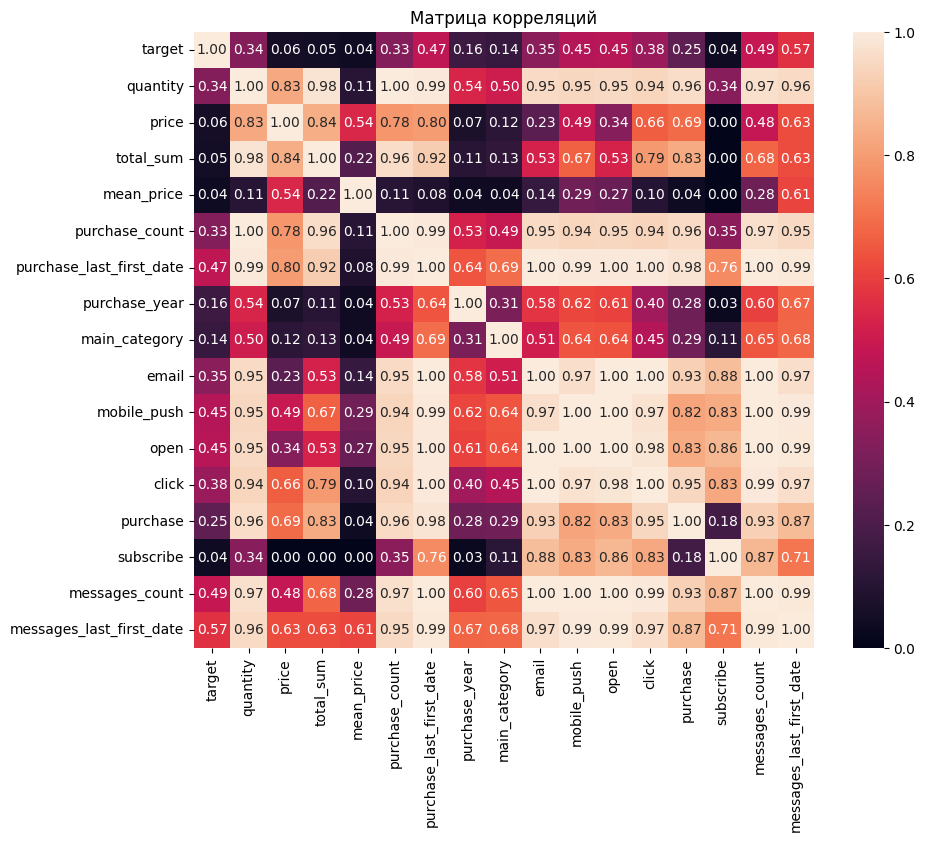

In [34]:
print("Построим матрицу корреляций, светлые тона ячеек говорят о сильной линейной зависимости, а тёмные — о слабой:")
plt.figure(figsize=(10,8))
plt.title("Матрица корреляций")
sns.heatmap(data.reset_index(drop=True).phik_matrix(interval_cols=['total_sum', 'price', 'mean_price']), annot=True, fmt='.2f')
plt.show()

Матрица корреляций показала мультиколлениарность (в данном случае буду считать только значение 1.0 между обучающими признаками, иначе признаков соовсем не останется) между признаками 'quantity' и 'purchase_count', 'purchase_last_first_date' и 'email'/'mobile_push'/'open'/'click'/'messages_count'. Для более качественного обучения необходимо отобрать и удалить по одному признаку из мультиколлениарной пары. Таким образом, в обучение не войдут следующие признаки: 'quantity', 'purchase_last_first_date', 'email',	'mobile_push',	'open'.        
Что касается зависимостей целевого признака 'target', то наиболее высокая положительная корреляция у целевого признака наблюдается с признаком 'messages_last_first_date', который отражает количество дней между последним и первым сообщением для каждого отдельного клиента. Можно предположить, что чем больше сообщений получил клиент, тем выше выроятность того, что клиент соврешит покупку.

### Вывод по Шаг 1. Подготовка данных:

В ходе данного шага все 3 датафрейма были успешно открыты и предобработаны. Были обнаружены и удалены явные дубликаты, найдены и учтены аномалии, настроены типы данных. Были созданы новые признаки в агрегированных по столбцу 'client_id' датафреймах 'purchases' и 'messages', на основании датафрейма 'binary' и 2х агрегированных датафреймах создан объединенный датафрейм 'data'.     

В ходе корреляционного анализа удалось выяснить, что наиболее высокая положительная корреляция у целевого признака 'target' наблюдается с признаком 'messages_last_first_date', который отражает количество дней между последним и первым сообщением для каждого отдельного клиента. Можно предположить, что чем больше сообщений получил клиент, тем выше выроятность того, что клиент соврешит покупку. Также матрица корреляций показала мультиколлениарность между обучающими признаками, в обучение не войдут следующие признаки: 'quantity', 'purchase_last_first_date', 'email',	'mobile_push',	'open'.        

### Шаг 2. Обучение моделей:

In [35]:
# Определили каегориальные и количественны признаки
ohe_columns = ['main_category']
num_columns = ['price',	'total_sum',	'mean_price', 'purchase_count',	'purchase_year',	
               'main_category',	'click',	'purchase',	'subscribe', 'messages_count', 'messages_last_first_date']

RANDOM_STATE = 42  
TEST_SIZE = 0.3

# Разбили данные на тренировочную (70%) и тестовую (30%) выборки
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['target', 'quantity', 'purchase_last_first_date', 'email',	'mobile_push',	'open'], axis=1),
    data['target'],
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE,
    stratify = data['target'])

In [36]:
display(f"Размеры тренировочной выборки: {X_train.shape, y_train.shape}")
display(f"Размеры тестовой выборки: {X_test.shape, y_test.shape}")

'Размеры тренировочной выборки: ((56495, 11), (56495,))'

'Размеры тестовой выборки: ((24213, 11), (24213,))'

In [37]:
# Категориальные признаки закодируем OneHotEncoder, а количественные - StandardScaler 
data_preprocessor = ColumnTransformer(
    [
        ('ohe', OneHotEncoder(drop ='first', handle_unknown ='ignore', sparse_output = False), ohe_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder ='passthrough'
)      

In [38]:
# Создан итоговый пайплайн
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression(random_state = RANDOM_STATE))
])

In [39]:
# Определены параметры моделей
param_grid = [
      {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]   
    },
    
     {
        'models': [CatBoostClassifier(loss_function="Logloss")],
        'models__iterations': [100, 200, 300],
        'models__learning_rate': [0.1, 0.2, 0.3],
        'models__depth': [1, 5, 10],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(),  'passthrough']  
    },
    
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
        
] 

param_grid

[{'models': [KNeighborsClassifier()],
  'models__n_neighbors': range(1, 10),
  'preprocessor__num': [StandardScaler(), MinMaxScaler()]},
 {'models': [<catboost.core.CatBoostClassifier at 0x7d3e4a7df3d0>],
  'models__iterations': [100, 200, 300],
  'models__learning_rate': [0.1, 0.2, 0.3],
  'models__depth': [1, 5, 10],
  'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']},
 {'models': [LogisticRegression(random_state=42)],
  'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']}]

In [40]:
grid = GridSearchCV(
    pipe_final, 
    param_grid, 
    cv = 5,
    scoring='roc_auc', 
    n_jobs=-1
)
grid.fit(X_train, y_train)

0:	learn: 0.5927527	total: 98.2ms	remaining: 29.4s
1:	learn: 0.5325294	total: 142ms	remaining: 21.2s
2:	learn: 0.4978290	total: 183ms	remaining: 18.1s
3:	learn: 0.4793128	total: 221ms	remaining: 16.3s
4:	learn: 0.4544459	total: 262ms	remaining: 15.5s
5:	learn: 0.4314530	total: 302ms	remaining: 14.8s
6:	learn: 0.4204991	total: 343ms	remaining: 14.4s
7:	learn: 0.3892866	total: 378ms	remaining: 13.8s
8:	learn: 0.3815620	total: 411ms	remaining: 13.3s
9:	learn: 0.3708501	total: 444ms	remaining: 12.9s
10:	learn: 0.3511806	total: 480ms	remaining: 12.6s
11:	learn: 0.3326542	total: 515ms	remaining: 12.4s
12:	learn: 0.3206681	total: 548ms	remaining: 12.1s
13:	learn: 0.3041310	total: 583ms	remaining: 11.9s
14:	learn: 0.2932035	total: 618ms	remaining: 11.7s
15:	learn: 0.2843204	total: 652ms	remaining: 11.6s
16:	learn: 0.2753570	total: 687ms	remaining: 11.4s
17:	learn: 0.2708946	total: 721ms	remaining: 11.3s
18:	learn: 0.2669081	total: 754ms	remaining: 11.1s
19:	learn: 0.2615134	total: 788ms	remain

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['main_category']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['price',
                                                                          'total_sum',
                                                                          'mean_price',
                                                                          'purchase_count',
                                                                          'purchase_year',
                                                                          'main_category',
                                                                          'click',
                                                                          'purchase',
                                                                          'subscribe...
                         {'models': [<catboost.core.CatBoostClassifier object at 0x7d3e4a7df3d0>],
                          'models__depth': [1, 5, 10],
                          'models__iterations': [100, 200, 300],
                          'models__learning_rate': [0.1, 0.2, 0.3],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']},
                         {'models': [LogisticRegression(random_state=42)],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']}],
             scoring='roc_auc')

In [41]:
grid.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['main_category']),
                                                 ('num', StandardScaler(),
                                                  ['price', 'total_sum',
                                                   'mean_price',
                                                   'purchase_count',
                                                   'purchase_year',
                                                   'main_category', 'click',
                                                   'purchase', 'subscribe',
                                                   'messages_count',
                                                   'messages_last_first_date'])])),
                ('models',
                 <catboost.core.CatBoostClassifier object at 0x7d3e4a7fb6a0>)])

In [42]:
pd.DataFrame(grid.cv_results_).loc[:, ['params', 'mean_test_score', 'rank_test_score']].sort_values(by='rank_test_score')  

,params,mean_test_score,rank_test_score
97,{'models': <catboost.core.CatBoostClassifier o...,1.00,1
96,{'models': <catboost.core.CatBoostClassifier o...,1.00,1
98,{'models': <catboost.core.CatBoostClassifier o...,1.00,1
95,{'models': <catboost.core.CatBoostClassifier o...,1.00,4
93,{'models': <catboost.core.CatBoostClassifier o...,1.00,4
...,...,...,...
19,{'models': <catboost.core.CatBoostClassifier o...,0.75,97
18,{'models': <catboost.core.CatBoostClassifier o...,0.75,97
99,{'models': LogisticRegression(random_state=42)...,0.73,100
100,{'models': LogisticRegression(random_state=42)...,0.73,101


In [43]:
print(f'ROC-AUC лучшей модели на валидационной выборке (кросс-валидация): {grid.best_score_.round(2)}')

ROC-AUC лучшей модели на валидационной выборке (кросс-валидация): 1.0


### Вывод по Шаг 2. Обучение моделей:

На данном шаге был создан пайплайн, категориальные признаки были закодированы OneHotEncoder, а количественные - StandardScaler и MinMaxScaler. Среди 3х моделей LogisticRegression, KNeighborsClassifier и CatBoostRegressor лучшей моделью при проверке через кросс-валидацию оказалась модель градиентного бустинга CatBoostClassifier, которая показала безупречную метрику ROC-AUC (1.0). 

### Шаг 3. Анализ моделей:

In [44]:
# Лучшая модель (CatBoostClassifier) сохранена в переменную "best_model"
best_model = grid.best_estimator_


# Полученные предсказания сохранены в датафрейм "predictions"
y_pred = best_model.predict(X_test)
predictions = pd.DataFrame(y_pred, columns=['target_predicted'])

Площадь ROC-кривой: 1.00


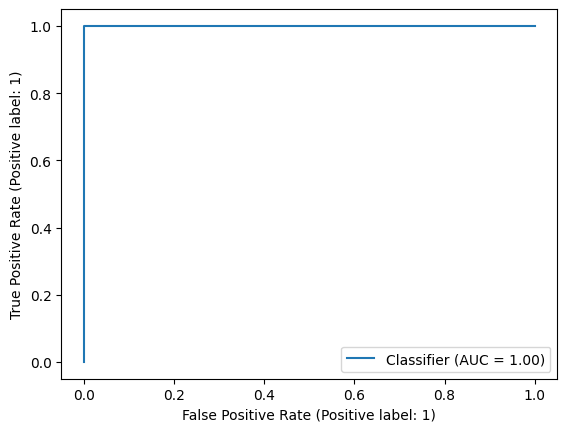

In [45]:
probabilities = grid.predict_proba(X_test)
probabilities_one = probabilities[:, 1]
roc_auc = roc_auc_score(y_test, probabilities_one)
print(f'Площадь ROC-кривой: {roc_auc:.2f}')
RocCurveDisplay.from_predictions(y_test, probabilities_one)

На тестовых данных лучшая модель (CatBoostClassifier) также отработала безупречно (метрика ROC-AUC также 1.0).

Построим матрицу ошибок:


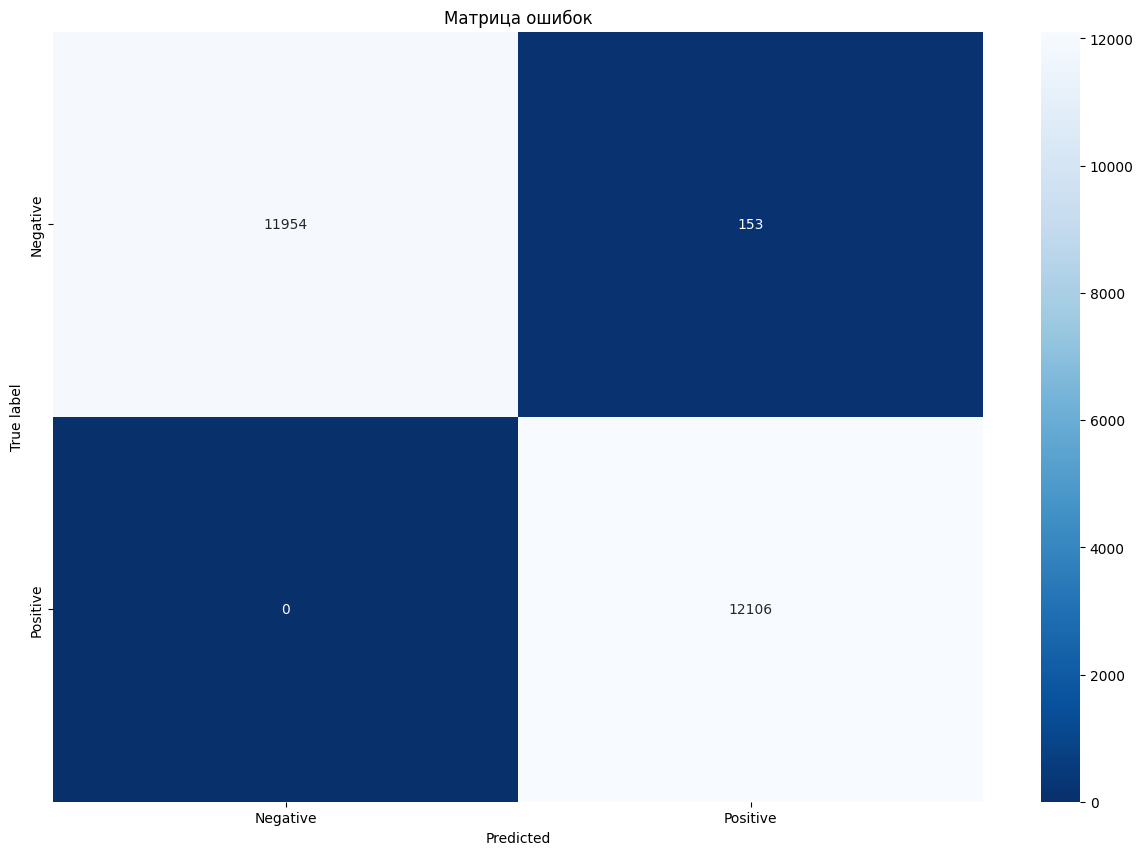

In [46]:
print("Построим матрицу ошибок:")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(15, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.ylabel('True label')
plt.xlabel('Predicted')
plt.title('Матрица ошибок')
plt.show()

Матрица ошибок показывает, что модель совершает ошибки 1го рода - клиентов, которые в итоге не совершат покупку (класс 0), модель определяет, как клиентов, которые покупку вероятнее всего сделают (класс 1). При этом модель не ошиблась при определении клиентов, готовых совершить покупку (класс 1). Думаю, что в данном случае, когда ошибка совсем небольшая, можно попробовать в дальнейшем уменьшить текущую ошибку 1го рода, увеличив выборку и ее репрезентативность (больше разнообразных примеров обоих классов). 

### Вывод Шаг 3. Анализ моделей:

На данном шаге лучшая модель(CatBoostClassifier) была более детально изучена и протестирована.   
На тестовых данных лучшая модель (CatBoostClassifier) также отработала безупречно (метрика ROC-AUC также 1.0) и доказала свою эффективность. Однако, модель совершает небольшое количество ошибок 1го рода, что означает, что клиентов, которые в итоге не совершат покупку (класс 0), модель определяет, как клиентов, которые покупку вероятнее всего совершат (класс 1). При этом модель не ошиблась при определении клиентов, готовых совершить покупку (класс 1). В данном случае, когда ошибка совсем небольшая, можно попробовать в дальнейшем уменьшить текущую ошибку 1го рода, увеличив выборку и ее репрезентативность (больше разнообразных примеров обоих классов).
Лучшая модель (CatBoostClassifier) сохранена в переменную "best_model". Полученные предсказания сохранены в датафрейм "predictions". 

### Общий вывод:

При выполнении данного проекта все 3 датафрейма были успешно открыты и предобработаны. Были обнаружены и удалены явные дубликаты, найдены и учтены аномалии, настроены типы данных, созданы новые признаки.        

В ходе корреляционного анализа удалось выяснить, что наиболее высокая положительная корреляция у целевого признака 'target' наблюдается с признаком 'messages_last_first_date', который отражает количество дней между последним и первым сообщением для каждого отдельного клиента. Можно предположить, что чем больше сообщений получил клиент, тем выше выроятность того, что клиент соврешит покупку. Также была обнаружена и устранена мультиколлениарность между обучающими признаками.    

Далее был создан пайплайн, категориальные признаки были закодированы OneHotEncoder, а количественные - StandardScaler и MinMaxScaler. Среди 3х моделей LogisticRegression, KNeighborsClassifier и CatBoostRegressor лучшей моделью при проверке через кросс-валидацию оказалась модель градиентного бустинга CatBoostClassifier, которая показала безупречную метрику ROC-AUC (1.0).  

На тестовых данных лучшая модель (CatBoostClassifier) также отработала безупречно (метрика ROC-AUC также 1.0) и доказала свою эффективность. Однако, модель совершает небольшое количество ошибок 1го рода, что означает, что клиентов, которые в итоге не совершат покупку (класс 0), модель определяет, как клиентов, которые покупку вероятнее всего совершат (класс 1). При этом модель не ошиблась при определении клиентов, готовых совершить покупку (класс 1). В данном случае, когда ошибка совсем небольшая, можно попробовать в дальнейшем уменьшить текущую ошибку 1го рода, увеличив выборку и ее репрезентативность (больше разнообразных примеров обоих классов).        
Лучшая модель (CatBoostClassifier) сохранена в переменную "best_model". Полученные предсказания сохранены в датафрейм "predictions". Таким образом, цель проекта была достигнута.    